#Inverted Pendulum Deep Q Learning Simulation



---



This notebook serves as the codebase for my Reinforcement Learning Approach to Cartpole Research Project. The following code is based on the DQN implementation by [Mike Wang](https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc), and is adapted and experimented to understand the process of deep q learning. Although much of the architecture and hyperparameters are maintained from the original implementation, graphs, renderings, and re-structuring is applied to visualize and understand the DQN process.

**Dependencies and environment setup**

In [ ]:
#Dependencies for DQN
import gym
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from collections import deque
import time
import random

#Create environment and set random seed
env = gym.make('CartPole-v1')
env.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

#Display the range of the action and observation space
print("Action Space: {}".format(env.action_space))
print("State space: {}".format(env.observation_space))

Action Space: Discrete(2)
State space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


**Function to set up neural network architecture**

In [ ]:
#Create and compile 4x24x12x2 model architecture
def DQN(state_shape, action_shape):
  init = tf.keras.initializers.HeUniform()
  model = keras.Sequential()
  model.add(keras.layers.Dense(24, input_shape=state_shape, activation='relu', kernel_initializer=init))
  model.add(keras.layers.Dense(12, activation='relu', kernel_initializer=init))
  model.add(keras.layers.Dense(action_shape, activation='linear', kernel_initializer=init))
  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
  return model

**Training loop function**

In [ ]:
#Main training loop
def train(env, replay_memory, model, target_model, done):
    #Training hyperparameters
    learning_rate = 0.7
    discount_factor = 0.6
    batch_size = 128

    #Create and process minibatch for training
    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([i[0] for i in mini_batch])
    new_current_states = np.array([j[3] for j in mini_batch])
    current_qs_list = model.predict(current_states, verbose=None)
    future_qs_list = target_model.predict(new_current_states, verbose=None)

    #variables to hold tranining data/lables
    x = []
    y = []

    #calculate updated q-value for each state using bellman equation to use as a target
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        #Find max return of state
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        #bellman equation update
        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q

        #add data to training set
        x.append(observation)
        y.append(current_qs)

    #train the model using current q values and lables from target network and bellman eq.
    model.fit(np.array(x), np.array(y), batch_size=batch_size, verbose=0, shuffle=True)

**Main deep q learning iteration loop with e-greedy and replay buffer**

In [ ]:
#DQN hyperparameters
train_episodes = 300
epsilon = 1
max_epsilon = 1
min_epsilon = 0.01
decay = 0.01

#Main model
model = DQN(env.observation_space.shape, env.action_space.n)

#Target model (updated every 100 steps)
target_model = DQN(env.observation_space.shape, env.action_space.n)
target_model.set_weights(model.get_weights())

#Set up replay memory buffer
replay_memory = deque(maxlen=50_000)

#Counters for main loop
target_update_counter = 0
steps_to_update_target_model = 0
rewards_plot = []

#Loop to initiate the number of cartpole simulation episodes
for episode in range(train_episodes):
    #start with reset environment
    total_training_rewards = 0
    observation = env.reset()
    done = False

    #For each episode
    while not done:
        steps_to_update_target_model += 1
        random_number = np.random.rand()
        #conduct epsilon greedy choice
        if random_number <= epsilon:
            action = env.action_space.sample()
        #conduct max action choice
        else:
            #find max action
            encoded = observation
            encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
            predicted = model.predict(encoded_reshaped, verbose=None).flatten()
            action = np.argmax(predicted)
        #commit max action and get new state and reward
        new_observation, reward, done, info = env.step(action)
        #add state, action, reward, new state tuple to memory buffer
        replay_memory.append([observation, action, reward, new_observation, done])

        #Train main model every 4 steps only if replay buffer is large enough
        if steps_to_update_target_model % 4 == 0 or done:
          if len(replay_memory) >= 1000:
            train(env, replay_memory, model, target_model, done)
        observation = new_observation
        total_training_rewards += reward

        #If the episode has ended
        if done:
            #print and save total reward from episode
            print('Total training rewards: {} for episode = {}'.format(total_training_rewards, episode))
            rewards_plot.append(total_training_rewards)

            #Update the target model by copying weights if at least 100 steps were taken
            if steps_to_update_target_model >= 100:
                print('Copying main network weights to the target network weights')
                target_model.set_weights(model.get_weights())
                steps_to_update_target_model = 0
            break
    #epsilon decay after each episode
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)

Total training rewards: 18.0 for episode = 0
Total training rewards: 18.0 for episode = 1
Total training rewards: 19.0 for episode = 2
Total training rewards: 23.0 for episode = 3
Total training rewards: 49.0 for episode = 4
Copying main network weights to the target network weights
Total training rewards: 39.0 for episode = 5
Total training rewards: 59.0 for episode = 6
Total training rewards: 33.0 for episode = 7
Copying main network weights to the target network weights
Total training rewards: 24.0 for episode = 8
Total training rewards: 13.0 for episode = 9
Total training rewards: 27.0 for episode = 10
Total training rewards: 53.0 for episode = 11
Copying main network weights to the target network weights
Total training rewards: 42.0 for episode = 12
Total training rewards: 49.0 for episode = 13
Total training rewards: 14.0 for episode = 14
Copying main network weights to the target network weights
Total training rewards: 14.0 for episode = 15
Total training rewards: 17.0 for episo

**Plot of reward by training iteration**

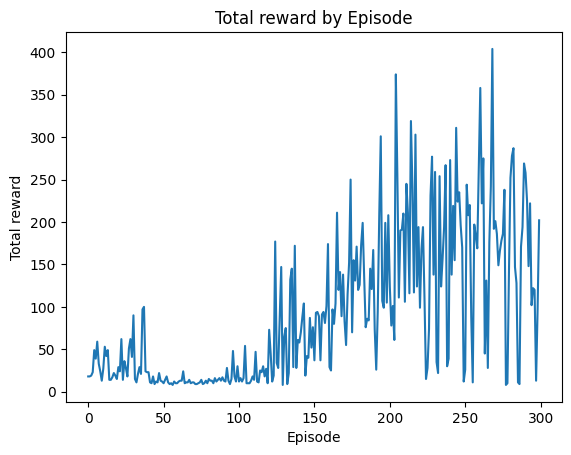

In [ ]:
#Plot the total reward by iteration
plt.plot(rewards_plot)
plt.title("Total reward by Episode")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.show()

##Render Trained Model
After training the DQN main network, the following code uses the network to make predictions for a single iteration of cartpole. The iteration is then recorded as a video, which is shown in the final code cell of this notebook.

In [ ]:
#Install libraries for rendering
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install pyvirtualdisplay
!apt-get install  xvfb
!apt-get install python-opengl ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl


In [ ]:
#Dependencies for rendering
from gym.wrappers import RecordVideo
import glob
from pyvirtualdisplay import Display
import os
import moviepy.editor
from IPython.display import clear_output

  np.bool8: (False, True),

  from scipy.ndimage.filters import sobel



**Show image of starting cartpole environment**

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



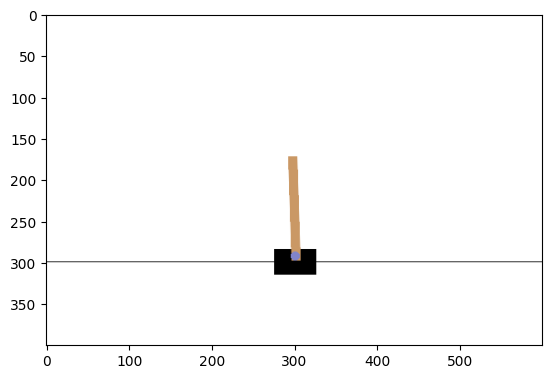

In [ ]:
#Show a static image of the starting state of cartpole
env.reset()
plt.imshow(env.render('rgb_array'))

In [ ]:
display = Display(visible=False, size=(1400, 900))
display.start()
os.environ["DISPLAY"] = f":{display.display}"

In [ ]:
#record video of one simulation of carpole using trained model
env = RecordVideo(gym.make("CartPole-v1"), "./mp4")
observation = env.reset()
clear_output()

done = False
i = 0
while not done:
    encoded = observation
    encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
    predicted = model.predict(encoded_reshaped, verbose=None).flatten()
    action = np.argmax(predicted)
    new_observation, reward, done, info = env.step(action)
    observation = new_observation
    i = i + 1
    if done:
        print("Episode finished after {} timesteps".format(i+1))
        break

  if not isinstance(terminated, (bool, np.bool8)):

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Episode finished after 216 timesteps


**Render final video of the trained agent simulating cartpole**

In [ ]:
#display final video
files = glob.glob(f'{env.video_folder}/{env.name_prefix}*.mp4')
moviepy.editor.ipython_display('/content/mp4/rl-video-episode-0.mp4')